# GO terms DEGs
In our transcriptomics visualization notebook, we exported some groups of genes that we want to get GO term enrichments for; here is where we'll do that, using the PANTHER API.

In [2]:
from os import listdir
from os.path import splitext
import requests
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import numpy as np
from upsetplot import from_contents, plot, UpSet
import warnings
import matplotlib.pyplot as plt

## Read in the data

In [17]:
data_dir = '../data/gene_lists/'
data = {}
for f in listdir(data_dir):
    with open(f'{data_dir}/{f}') as myf:
        data[splitext(f)[0]] = [l.strip() for l in myf.readlines()]

Define the semantic mapping for later use:

In [62]:
conditions_semantic = {
    '1h_vs_7h_2o2_gene_list': '7 hours vs. 1 hour at 2% oxygen',
    '1h_vs_7h_40o2_gene_list': '7 hours vs. 1 hour at 40% oxygen',
    '1h_vs_7h_21o2_gene_list': '7 hours vs. 1 hour at 21% oxygen',
    '1h_vs_7h_2o2_filtered_gene_list': '7 hours vs. 1 hour at 2% oxygen, filtered',
    '1h_vs_7h_40o2_filtered_gene_list': '7 hours vs. 1 hour at 40% oxygen, filtered',
    '1h_o2_40_21_gene_list': '40% vs. 21% oxygen at 1 hour',
    '7h_o2_2_21_gene_list': '2% vs. 21% oxygen at 7 hours',
    '1h_o2_2_21_gene_list': '2% vs. 21% oxygen at 1 hour',
    '7h_o2_40_21_gene_list': '40% vs. 21% oxygen at 7 hours'
}

Drop the reference list (only needed if doing local enrichment with GOAtools):

In [19]:
del data['reference_gene_list']

## Define API call function
We're going to use the [PANTHER API](https://pantherdb.org/services/openAPISpec.jsp) to do our GO term enrichment.

In [3]:
def getPANTHER(query, checkPageInfo=True):
    """
    Get GO terms from a mmultiple-page search result.
    """
    # Check number of pages
    r = requests.get(query, headers={ "Accept" : "application/json"})
    if not r.ok:
      r.raise_for_status()
      sys.exit()
    responseBody = r.json()
    overall_jsons = responseBody['results']

    return overall_jsons

## Formulate queries and make API call

In [26]:
enrichments = defaultdict(dict)
for comp, genes in tqdm(data.items()):
    gene_list = ','.join(genes)
    enriches = {}
    for go_name, go_set in {
                            'GO%3A0008150': 'biological_process',
                            'GO%3A0003674': 'molecular_function',
                            'GO%3A0005575': 'cellular_component'
                            }.items():
        enrich_query = f'https://pantherdb.org/services/oai/pantherdb/enrich/overrep?geneInputList={gene_list}&organism=3702&annotDataSet={go_name}&enrichmentTestType=FISHER&correction=FDR'
        result_json = getPANTHER(enrich_query)
        enriches[go_set] = result_json
    enrichments[comp] = enriches

100%|██████████| 9/9 [01:30<00:00, 10.06s/it]


## Process results
Note that the chimeric transcripts and novel genes are not able to be mapped to GO terms, and so are excluded. In the `unmapped_id` lists there are also some normal-looking TAIR ID's; I assume that there is some base error in mapping genes to GO terms wtih this tool.

In [5]:
def processGOenrichments(enrichments, data, conditions_semantic):
    """
    Make a summary dataframe with GO terms from each aspect that are enriched
    in each group, and print a summary of the numbers.
    """
    processed_go = {
        'group': [],
        'aspect': [],
        'term': [],
        'GOid': [],
        'p_value_fdr': []
    }
    for group, res in enrichments.items():
        for aspect in res:
            for termDict in res[aspect]['result']:
                if termDict['fdr'] < 0.05:
                    processed_go['group'].append(group)
                    processed_go['aspect'].append(aspect)
                    processed_go['term'].append(termDict['term']['label'])
                    try:
                        processed_go['GOid'].append(termDict['term']['id'])
                    except KeyError:
                        processed_go['GOid'].append(np.nan)
                    processed_go['p_value_fdr'].append(termDict['fdr'])

    go_results = pd.DataFrame(processed_go)
    go_results = go_results.set_index(['group', 'aspect']).sort_index()

    for group in data:
        print(f'\nFor comparison group {conditions_semantic[group]}, there are...')
        for aspect in ['biological_process', 'molecular_function', 'cellular_component']:
            try:
                print(f'{len(go_results.loc[(group, aspect)])} {aspect} GO terms')
            except KeyError:
                print(f'0 {aspect} GO terms')
        print(f'... enriched, for a total of {len(data[group])} genes in the comparison.\n')

    return go_results

In [116]:
go_enrichment_data = processGOenrichments(enrichments, data, conditions_semantic)
go_enrichment_data.head()


For comparison group 7 hours vs. 1 hour at 21% oxygen, there are...
138 biological_process GO terms
28 molecular_function GO terms
60 cellular_component GO terms
... enriched, for a total of 1166 genes in the comparison.


For comparison group 7 hours vs. 1 hour at 40% oxygen, there are...
149 biological_process GO terms
19 molecular_function GO terms
82 cellular_component GO terms
... enriched, for a total of 2094 genes in the comparison.


For comparison group 40% vs. 21% oxygen at 1 hour, there are...
6 biological_process GO terms
1 molecular_function GO terms
0 cellular_component GO terms
... enriched, for a total of 68 genes in the comparison.


For comparison group 7 hours vs. 1 hour at 2% oxygen, filtered, there are...
181 biological_process GO terms
31 molecular_function GO terms
51 cellular_component GO terms
... enriched, for a total of 1492 genes in the comparison.


For comparison group 2% vs. 21% oxygen at 1 hour, there are...
16 biological_process GO terms
5 molecular_fu

term  \
group                aspect                                                             
1h_o2_2_21_gene_list biological_process                  xyloglucan metabolic process   
                     biological_process                  cellular response to hypoxia   
                     biological_process  cellular response to decreased oxygen levels   
                     biological_process            cellular response to oxygen levels   
                     biological_process                          response to chemical   

                                               GOid  p_value_fdr  
group                aspect                                       
1h_o2_2_21_gene_list biological_process  GO:0010411     0.000136  
                     biological_process  GO:0071456     0.000108  
                     biological_process  GO:0036294     0.000076  
                     biological_process  GO:0071453     0.000059  
                     biological_process  GO:0042221     0.000060

Save the dataframe output, but replace outer index with semantic values first:

In [109]:
multi = go_enrichment_data.index.tolist()
multi_replace = pd.MultiIndex.from_tuples([(conditions_semantic[i], j) for i, j in multi])
go_enrichment_data.index = multi_replace
go_enrichment_data.head()

term  \
2% vs. 21% oxygen at 1 hour biological_process                  xyloglucan metabolic process   
                            biological_process                  cellular response to hypoxia   
                            biological_process  cellular response to decreased oxygen levels   
                            biological_process            cellular response to oxygen levels   
                            biological_process                          response to chemical   

                                                      GOid  p_value_fdr  
2% vs. 21% oxygen at 1 hour biological_process  GO:0010411     0.000136  
                            biological_process  GO:0071456     0.000108  
                            biological_process  GO:0036294     0.000076  
                            biological_process  GO:0071453     0.000059  
                            biological_process  GO:0042221     0.000060

In [110]:
go_enrichment_data.to_csv('../data/PANTHER_GO_enrichments_all_categories_18Mar2025.csv', index=True)

I'd like to know what terms, if any, overlap between the groups. Let's make some UpSet plots. I mostly care about the same kinds of comparisons that I did for the differential expression, so let's make one plot for each aspect for each of the time and oxygen comparisons.

In [90]:
go_enrich_time = go_enrichment_data[go_enrichment_data.index.get_level_values(0).isin(['1h_vs_7h_2o2_gene_list',
    '1h_vs_7h_40o2_gene_list',
    '1h_vs_7h_21o2_gene_list',
    '1h_vs_7h_2o2_filtered_gene_list',
    '1h_vs_7h_40o2_filtered_gene_list'])]

go_enrich_o2 = go_enrichment_data[go_enrichment_data.index.get_level_values(0).isin(['1h_o2_40_21_gene_list',
    '7h_o2_2_21_gene_list',
    '1h_o2_2_21_gene_list',
    '7h_o2_40_21_gene_list'])]

In [101]:
def plot_go_enrichment_overlaps(enriches, conditions_semantic):
    """
    Plot enrichment overlaps for each of the three aspects for a set of groups.
    """
    warnings.filterwarnings('ignore') 
    for aspect in set(enriches.index.get_level_values(1)):
        go_terms = {}
        for group in set(enriches.index.get_level_values(0)):
            try:
                go_terms[conditions_semantic[group]] = list(set(enriches.loc[(group, aspect), 'GOid'].tolist()))
            except KeyError:
                go_terms[conditions_semantic[group]] = []
        to_plot = from_contents(go_terms)
        plot(to_plot, show_counts=True, sort_categories_by='input')
        plt.title(aspect)

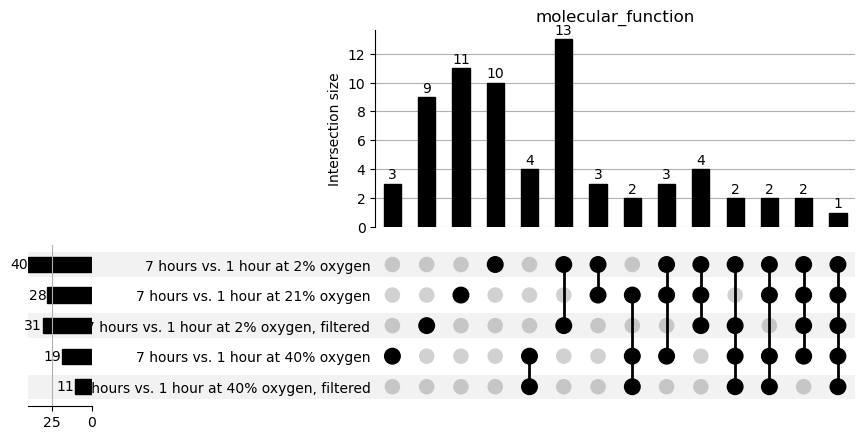

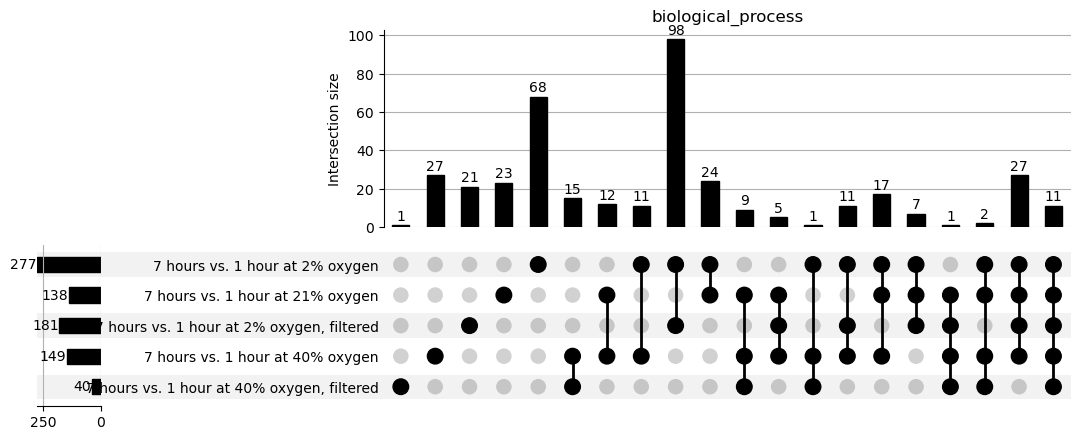

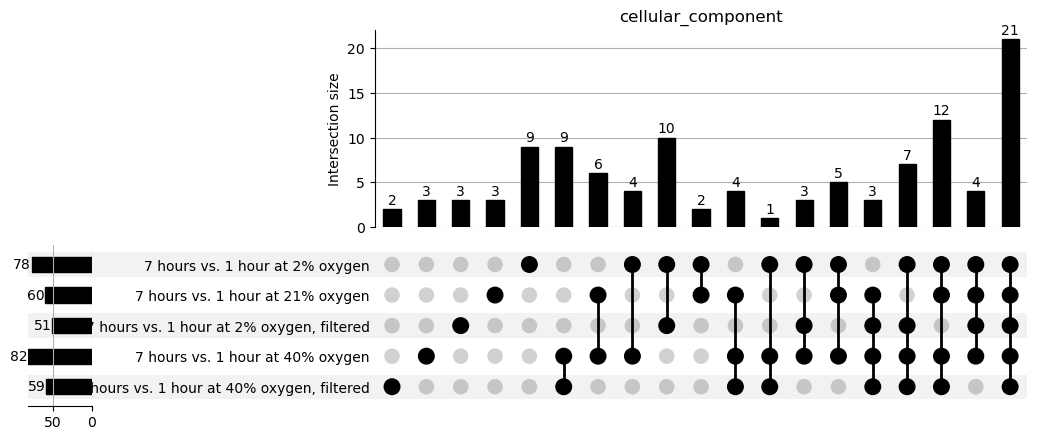

In [102]:
plot_go_enrichment_overlaps(go_enrich_time, conditions_semantic)

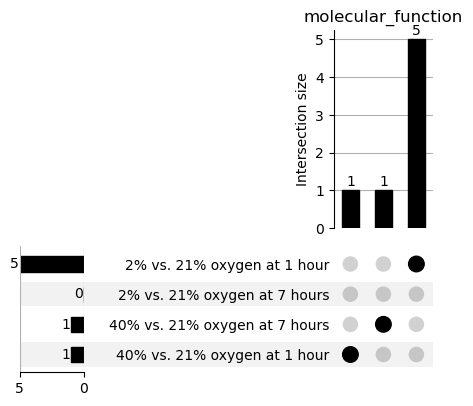

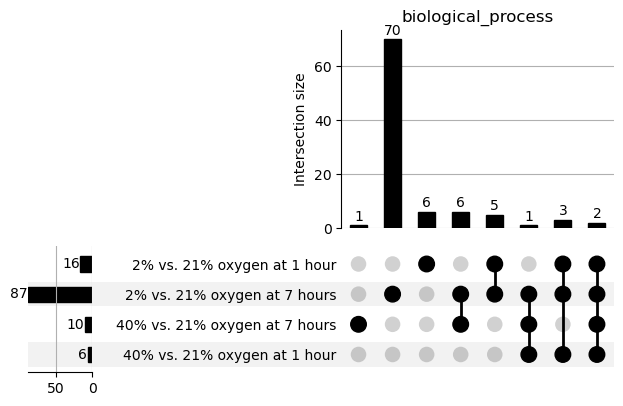

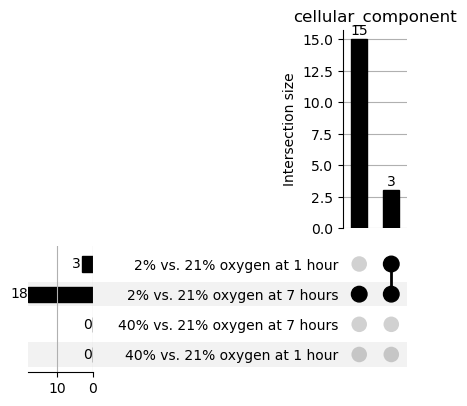

In [103]:
plot_go_enrichment_overlaps(go_enrich_o2, conditions_semantic)

## Additional GO analyses
### Oxygen concentration overlaps

In [1]:
all_o2_comps = {}
with open('../data/gene_lists/2o2_all_comps_overlaps_gene_list.txt') as f:
    all_o2_comps['2o2'] = [l.strip() for l in f.readlines()]
with open('../data/gene_lists/40o2_all_comps_overlaps_gene_list.txt') as f:
    all_o2_comps['40o2'] = [l.strip() for l in f.readlines()]

In [4]:
o2_enrichments = defaultdict(dict)
for comp, genes in tqdm(all_o2_comps.items()):
    gene_list = ','.join(genes)
    enriches = {}
    for go_name, go_set in {
                            'GO%3A0008150': 'biological_process',
                            'GO%3A0003674': 'molecular_function',
                            'GO%3A0005575': 'cellular_component'
                            }.items():
        enrich_query = f'https://pantherdb.org/services/oai/pantherdb/enrich/overrep?geneInputList={gene_list}&organism=3702&annotDataSet={go_name}&enrichmentTestType=FISHER&correction=FDR'
        result_json = getPANTHER(enrich_query)
        enriches[go_set] = result_json
    o2_enrichments[comp] = enriches

100%|██████████| 2/2 [00:15<00:00,  7.88s/it]


In [6]:
o2_conditions_semantic = {
    '2o2': '2% oxygen, all comparisons',
    '40o2': '40% oxygen, all comparisons'
}

In [7]:
o2_go_enrichment_data = processGOenrichments(o2_enrichments, all_o2_comps, o2_conditions_semantic)
o2_go_enrichment_data.head()


For comparison group 2% oxygen, all comparisons, there are...
50 biological_process GO terms
0 molecular_function GO terms
0 cellular_component GO terms
... enriched, for a total of 207 genes in the comparison.


For comparison group 40% oxygen, all comparisons, there are...
0 biological_process GO terms
0 molecular_function GO terms
0 cellular_component GO terms
... enriched, for a total of 8 genes in the comparison.



term  \
group aspect                                                                  
2o2   biological_process                               response to chemical   
      biological_process                               response to stimulus   
      biological_process                        cellular response to stress   
      biological_process  multicellular organismal-level iron ion homeos...   
      biological_process  multicellular organismal-level chemical homeos...   

                                GOid   p_value_fdr  
group aspect                                        
2o2   biological_process  GO:0042221  5.372990e-13  
      biological_process  GO:0050896  7.561177e-13  
      biological_process  GO:0033554  1.322829e-08  
      biological_process  GO:0060586  1.648962e-08  
      biological_process  GO:0140962  3.178490e-08

In [8]:
o2_go_enrichment_data.to_csv('../data/PANTHER_GO_enrichments_all_o2_comparisons_19March2025.csv', index=True)